In [36]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [37]:
csv_files = glob.glob('*.{}'.format('csv'))
csv_files = sorted(csv_files)

In [38]:
csv_files

['202001-citibike-tripdata.csv',
 '202002-citibike-tripdata.csv',
 '202003-citibike-tripdata.csv',
 '202004-citibike-tripdata.csv',
 '202005-citibike-tripdata.csv',
 '202006-citibike-tripdata.csv',
 '202007-citibike-tripdata.csv',
 '202008-citibike-tripdata.csv',
 '202009-citibike-tripdata.csv',
 '202010-citibike-tripdata.csv',
 '202011-citibike-tripdata.csv',
 '202012-citibike-tripdata.csv']

In [39]:
df_concat = pd.concat([pd.read_csv(f, usecols = ['starttime', 'start station id', 'tripduration'],
                                   low_memory=False) for f in csv_files ], ignore_index=True)
df_concat.head()

,tripduration,starttime,start station id
0,789,2020-01-01 00:00:55.3900,504
1,1541,2020-01-01 00:01:08.1020,3423
2,1464,2020-01-01 00:01:42.1400,3687
3,592,2020-01-01 00:01:45.5610,346
4,702,2020-01-01 00:01:45.7880,372


In [41]:
#To get most used and least used station ids
dict_id_count = {}
for i in df_concat['start station id'].unique():
    dict_id_count[i] = (df_concat['start station id'] == i).sum()
dict_id_count = pd.DataFrame.from_dict(dict_id_count, orient='index', columns=['count'])

dict_id_count = dict_id_count.sort_values('count')
leastFreq = list(dict_id_count[:10].index)
mostFreq = list(dict_id_count[-20:].index)
# print(mostFreq, leastFreq)

# df_concat['starttime'] = pd.to_datetime(df_concat['starttime'])
df_concat['c'] = np.ones((df_concat.shape[0]))

In [42]:
df_concat.index = df_concat['starttime']

In [43]:
grouper = df_concat.groupby([pd.Grouper(freq='1D'), 'start station id'])

In [44]:
grouper['c'].sum().unstack()

start station id,72,79,82,83,116,119,120,127,128,143,...,4280,4302,4304,4305,4306,4309,4310,4311,4328,4332
starttime,,,,,,,,,,,,,,,,,,,,,
2020-01-01,39.0,15.0,16.0,16.0,70.0,19.0,9.0,34.0,46.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,96.0,63.0,35.0,39.0,147.0,16.0,21.0,135.0,121.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,74.0,41.0,22.0,29.0,125.0,16.0,9.0,96.0,93.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,51.0,27.0,24.0,30.0,110.0,12.0,30.0,89.0,96.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,51.0,32.0,19.0,38.0,108.0,14.0,15.0,71.0,86.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,19.0,13.0,20.0,23.0,38.0,9.0,17.0,29.0,46.0,21.0,...,16.0,4.0,5.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN
2020-12-28,42.0,40.0,30.0,42.0,57.0,8.0,18.0,50.0,66.0,37.0,...,29.0,6.0,6.0,2.0,NaN,3.0,NaN,3.0,NaN,NaN
2020-12-29,33.0,18.0,27.0,26.0,43.0,12.0,21.0,46.0,70.0,36.0,...,18.0,7.0,NaN,10.0,NaN,5.0,NaN,5.0,NaN,NaN


In [45]:
train = grouper['c'].sum().unstack()
print(train.head())
print(train.info())
print(train.columns)
# train = train.fillna(0)

start station id  72    79    82    83     116   119   120    127    128   \
starttime                                                                   
2020-01-01        39.0  15.0  16.0  16.0   70.0  19.0   9.0   34.0   46.0   
2020-01-02        96.0  63.0  35.0  39.0  147.0  16.0  21.0  135.0  121.0   
2020-01-03        74.0  41.0  22.0  29.0  125.0  16.0   9.0   96.0   93.0   
2020-01-04        51.0  27.0  24.0  30.0  110.0  12.0  30.0   89.0   96.0   
2020-01-05        51.0  32.0  19.0  38.0  108.0  14.0  15.0   71.0   86.0   

start station id  143   ...  4280  4302  4304  4305  4306  4309  4310  4311  \
starttime               ...                                                   
2020-01-01        20.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2020-01-02        55.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2020-01-03        41.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2020-01-04        31.0  ...   NaN   NaN   NaN   NaN   NaN   NaN  

Text(0, 0.5, 'Ride count')

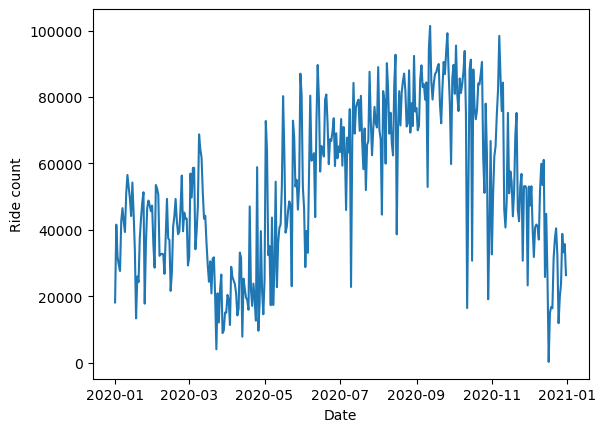

In [46]:
plt.plot(train.sum(axis=1))
plt.xlabel('Date')
plt.ylabel('Ride count')

In [47]:
test = pd.read_csv('Latest/202101-citibike-tripdata.csv', usecols = ['starttime', 'start station id', 'tripduration']
                  ,low_memory=False)
test['starttime'] = pd.to_datetime(test['starttime'])
test['c'] = np.ones((test.shape[0]))
test.index = test['starttime']
grouper2 = test.groupby([pd.Grouper(freq='1D'), 'start station id'])
test = grouper2['c'].sum().unstack()
print(test.head())
print(test.info())
print(test.columns)

start station id  72    79    82    83    116   119   120   127   128   143   \
starttime                                                                      
2021-01-01        14.0  17.0  16.0  16.0  28.0   5.0   7.0  43.0  23.0  20.0   
2021-01-02        81.0  36.0  23.0  47.0  57.0   6.0  27.0  57.0  88.0  51.0   
2021-01-03         9.0   7.0   9.0  11.0  21.0   6.0   8.0  27.0  31.0   9.0   
2021-01-04        51.0  35.0  16.0  48.0  48.0  17.0  18.0  69.0  63.0  29.0   
2021-01-05        47.0  38.0  22.0  36.0  61.0  16.0  21.0  60.0  59.0  38.0   

start station id  ...  4320  4321  4327  4328  4329  4330  4331  4332  4386  \
starttime         ...                                                         
2021-01-01        ...   NaN   NaN   NaN   3.0   NaN   NaN   NaN   3.0   NaN   
2021-01-02        ...   NaN   NaN   NaN   9.0   NaN   NaN   NaN   1.0   NaN   
2021-01-03        ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   NaN   
2021-01-04        ...   NaN   NaN   NaN   Na

In [48]:
y_mean = []
rmses = []
for i in range(len(mostFreq)):
    df_temp_train = train[mostFreq[i]].to_frame()
#     df_temp_train.info()
    df_temp_train.reset_index(inplace=True)
    df_temp_train.rename({'starttime': 'ds', mostFreq[i]: "y"}, axis='columns', inplace=True)
    y_mean.append(df_temp_train['y'].dropna().values.mean())
#     df_temp_train
#     df_temp_train.describe()
    m = Prophet()
    m.fit(df_temp_train)
    future = m.make_future_dataframe(periods=31, freq = "D")
    forecast = m.predict(future)
#     test.tail()
    df_temp = test[mostFreq[i]].to_frame()
    df_temp.info()
    df_temp.reset_index(inplace=True)
    df_temp.rename({'starttime': 'ds', mostFreq[i]: "y"}, axis='columns', inplace=True) 
    pred = forecast['yhat'][-31:].values
    true_values = df_temp['y'].values
#     print(np.isnan(true_values).sum())
#     print((pred<0).sum())
    pred[pred<0] = 0
    e = mse(true_values, pred)
    rmses.append(np.sqrt(e))
#     plt.scatter(pred, true_values)

23:41:54 - cmdstanpy - INFO - Chain [1] start processing
23:41:54 - cmdstanpy - INFO - Chain [1] done processing
23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   501     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   468     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2006    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:55 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3812    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3435    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   368     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:56 - cmdstanpy - INFO - Chain [1] start processing
23:41:56 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3641    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3687    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   519     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   285     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   402     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3256    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   358     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3711    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:41:58 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   497     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   499     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   514     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   435     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   426     31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-01-01 to 2021-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3141    31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


In [49]:
# for x station_id:
# plt.plot(pred, label='pred')
# plt.plot(true_values)
# plt.legend()

In [50]:
print(y_mean,'\n', rmses)
print("Error percentages for 20 stations:", 100*np.array(rmses)/np.array(y_mean))
print("Average error percentage for 20 stations:", np.sum(100*np.array(rmses)/np.array(y_mean))/20)

[188.85245901639345, 190.3306010928962, 192.50824175824175, 193.7032967032967, 195.5041095890411, 198.8904109589041, 201.10192837465564, 202.0879120879121, 203.55464480874318, 204.74794520547945, 215.61157024793388, 218.64383561643837, 232.32142857142858, 232.56593406593407, 247.95316804407713, 253.74585635359117, 267.6236263736264, 271.0136612021858, 272.2301369863014, 275.28142076502735] 
 [55.13632741402931, 24.3279015428283, 55.79100267544318, 35.28095316301308, 43.53091170134996, 57.029251877864475, 46.172587738301466, 53.184794804644625, 35.78934571387996, 33.83548328203492, 42.42013671385624, 62.24498892739065, 45.56824942810919, 58.79065640916333, 42.770407135659866, 56.96839333954741, 77.62463185517211, 79.89169293026795, 67.8924498772816, 78.25973809935981]
Error percentages for 20 stations: [29.19545115 12.7819181  28.98109825 18.21391466 22.26598295 28.67370609
 22.95979363 26.31765268 17.58218082 16.5254324  19.67433226 28.46866858
 19.61431182 25.27913499 17.24938926 22.4

In [51]:
# y_mean = []
# rmses = []
# for i in range(len(leastFreq)):
#     df_temp_train = train[leastFreq[i]].to_frame()
# #     df_temp_train.info()
#     df_temp_train.reset_index(inplace=True)
#     df_temp_train.rename({'starttime': 'ds', leastFreq[i]: "y"}, axis='columns', inplace=True)
#     y_mean.append(df_temp_train['y'].dropna().values.mean())
# #     df_temp_train
# #     df_temp_train.describe()
#     m = Prophet()
#     m.fit(df_temp_train)
#     future = m.make_future_dataframe(periods=31, freq = "D")
#     forecast = m.predict(future)
# #     test.tail()
#     df_temp = test[leastFreq[i]].to_frame()
#     df_temp.info()
#     df_temp.reset_index(inplace=True)
#     df_temp.rename({'starttime': 'ds', leastFreq[i]: "y"}, axis='columns', inplace=True) 
#     pred = forecast['yhat'][-31:].values
#     true_values = df_temp['y'].values
#     print(np.isnan(true_values).sum())
#     print((pred<0).sum())
#     pred[pred<0] = 0
#     e = mse(true_values, pred)
#     rmses.append(np.sqrt(e))
#     plt.scatter(pred, true_values)

In [52]:
# print("Error percentages for 10 stations:", 100*np.array(rmses)/np.array(y_mean))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,96.119666,54.653133,242.842949,96.119666,96.119666,50.902924,50.902924,50.902924,50.902924,50.902924,50.902924,0.0,0.0,0.0,147.022590
1,2020-01-02,97.134118,27.784280,215.887791,97.134118,97.134118,27.497327,27.497327,27.497327,27.497327,27.497327,27.497327,0.0,0.0,0.0,124.631445
2,2020-01-03,98.148570,11.906797,196.669140,98.148570,98.148570,9.555678,9.555678,9.555678,9.555678,9.555678,9.555678,0.0,0.0,0.0,107.704247
3,2020-01-04,99.163021,-73.296100,112.320554,99.163021,99.163021,-79.591451,-79.591451,-79.591451,-79.591451,-79.591451,-79.591451,0.0,0.0,0.0,19.571570
4,2020-01-05,100.177473,-70.947569,112.874770,100.177473,100.177473,-83.392342,-83.392342,-83.392342,-83.392342,-83.392342,-83.392342,0.0,0.0,0.0,16.785132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2021-01-27,172.488759,124.430012,311.329955,166.877082,177.338203,50.902924,50.902924,50.902924,50.902924,50.902924,50.902924,0.0,0.0,0.0,223.391683
393,2021-01-28,170.468877,105.420143,291.398452,164.621801,175.649069,27.497327,27.497327,27.497327,27.497327,27.497327,27.497327,0.0,0.0,0.0,197.966204
394,2021-01-29,168.448996,88.060004,276.716961,162.160370,174.136209,9.555678,9.555678,9.555678,9.555678,9.555678,9.555678,0.0,0.0,0.0,178.004674
395,2021-01-30,166.429115,-6.488382,183.478897,159.845974,172.427234,-79.591451,-79.591451,-79.591451,-79.591451,-79.591451,-79.591451,0.0,0.0,0.0,86.837664


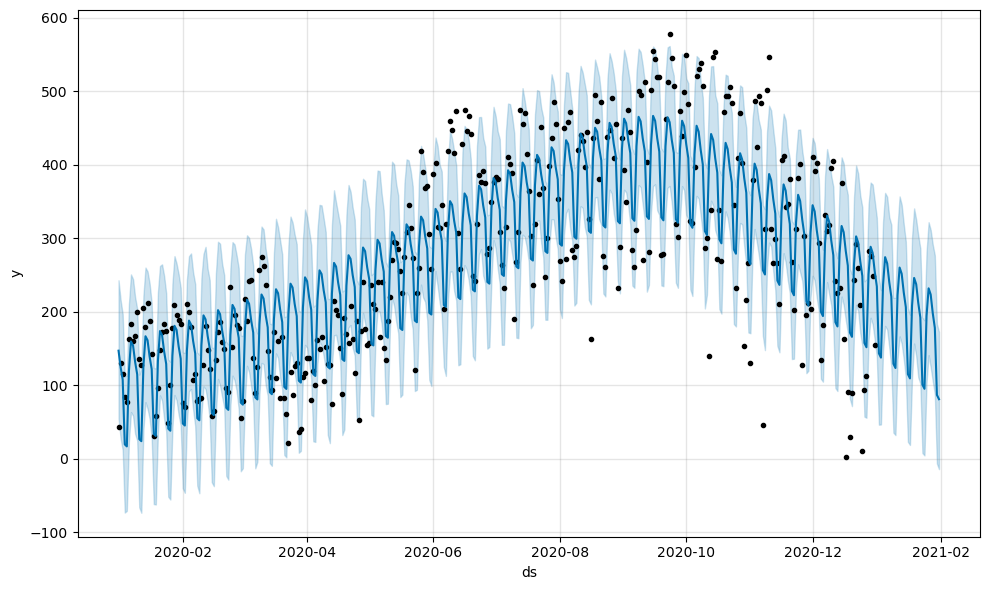

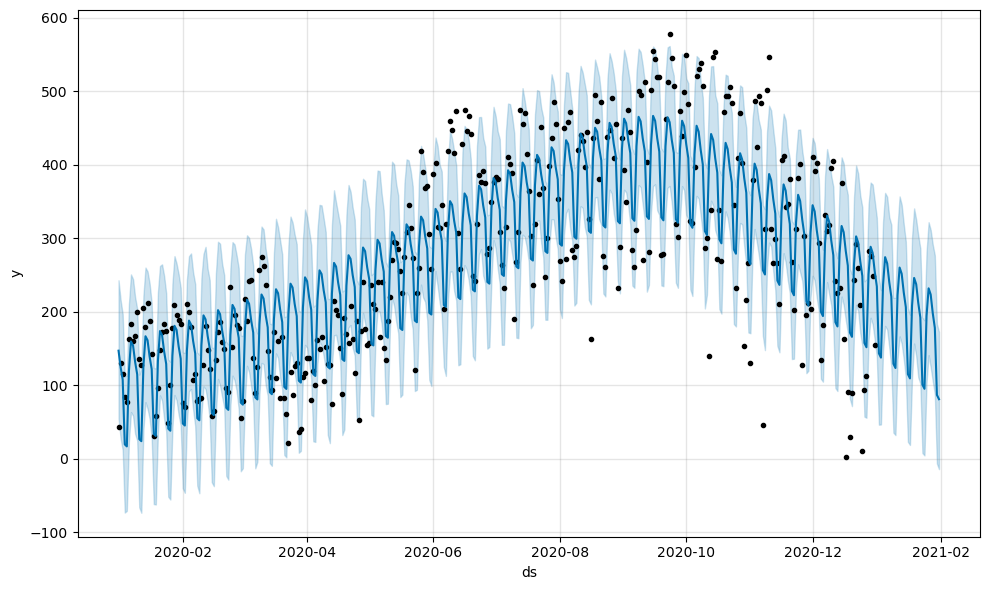

In [53]:
m.plot(forecast)

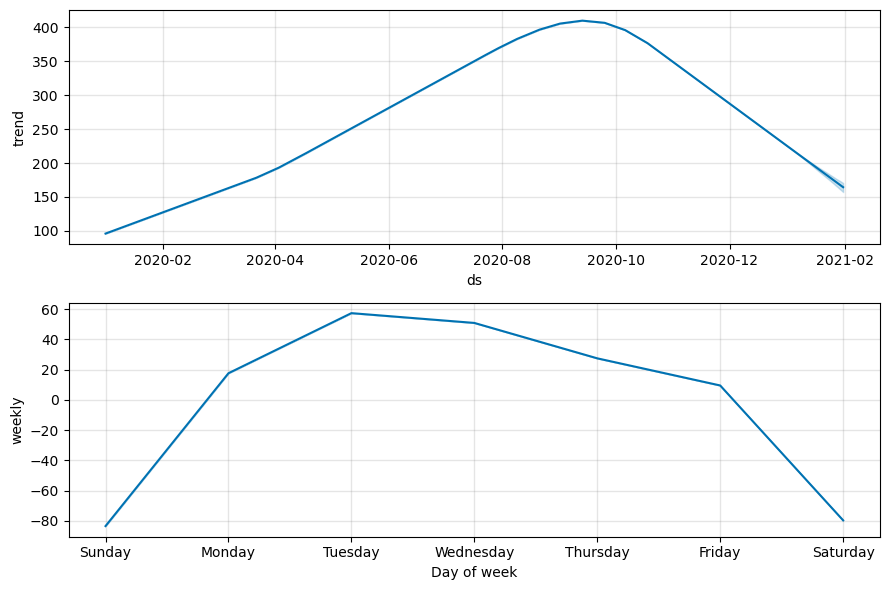

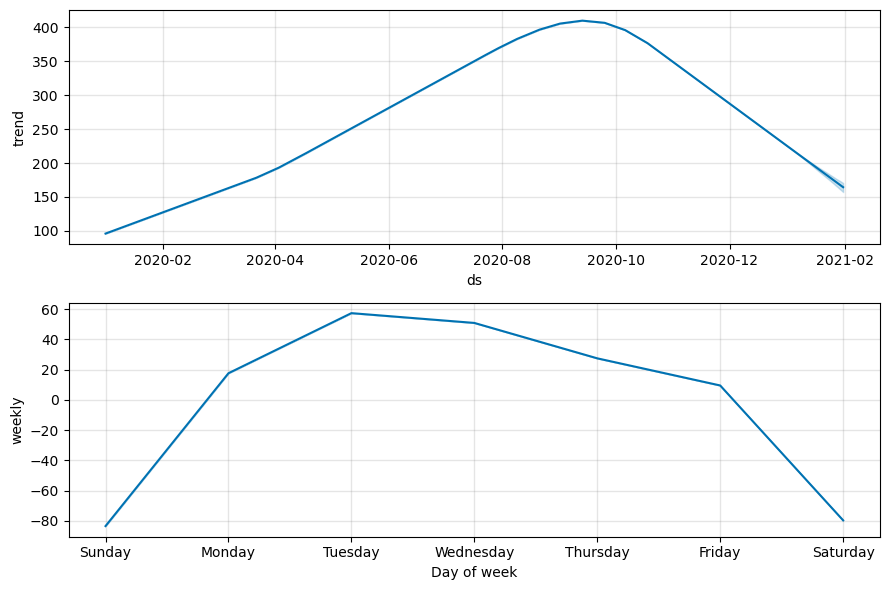

In [54]:
m.plot_components(forecast)
